In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import wandb
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [37]:
mpl.style.use('seaborn-v0_8')

In [75]:

class RotatedMNIST(MNIST):
    def __init__(self, *args, min_rotation_angle = 0, max_rotation_angle=180, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_rotation_angle = max_rotation_angle
        self.min_rotation_angle = min_rotation_angle

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        angle = random.uniform(self.min_rotation_angle, self.max_rotation_angle)
        img = transforms.functional.rotate(img, angle)
        return img, target

class FilteredRotatedMNIST(RotatedMNIST):
    def __init__(self, *args, excluded_labels=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.excluded_labels = excluded_labels if excluded_labels else []
        self.filtered_indices = [
            index for index, label in enumerate(self.targets) if label not in self.excluded_labels
        ]

    def __getitem__(self, index):
        index = self.filtered_indices[index]
        return super().__getitem__(index)

    def __len__(self):
        return len(self.filtered_indices)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

def visualize_rotated_images(images, labels, n=5):
    fig, ax = plt.subplots(n, n, figsize=(8, 8))
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            img = images[idx].numpy().squeeze()
            ax[i, j].imshow(img, cmap='gray')
            ax[i, j].set_title(f"Label: {labels[idx]}")
            ax[i, j].axis('off')
    plt.show()

def cross_entropy_uniform(log_probs: torch.Tensor, labels):
    n = log_probs.size(-1)
    uniform_probs = torch.ones(n) / n
    probs = log_probs.exp()
    loss = -torch.sum(uniform_probs * probs.log()) / n
    return loss


In [74]:
a = torch.ones((3,4,5,6))
a.size(-1)

6

In [28]:

# Hyperparameters
batch_size = 100
num_epochs = 10
learning_rate = 0.01
momentum = 0.9
min_rotation_angle = 0
max_rotation_angle = 180

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
x_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
x_loader = DataLoader(x_dataset, batch_size=batch_size, shuffle=True)
y_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = max_rotation_angle, max_rotation_angle=360-min_rotation_angle, excluded_labels=[0, 8, 9])
y_loader = DataLoader(y_dataset, batch_size=batch_size, shuffle=True)

# Log model architecture to Weights & Biases
wandb.init(project="rotated_mnist", name="single_hidden_layer_cnn")

# Model, Loss function, and Optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
wandb.watch(model)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(x_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = correct / labels.size(0)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(x_loader)}], Loss: {loss.item()}")

        # Log training loss to Weights & Biases
        wandb.log({"Training Loss": loss.item(), "Training Accuracy": batch_accuracy})

# Testing the model with rotated images

test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {test_accuracy}%')

# Log test accuracy to Weights & Biases
wandb.log({"Test Accuracy": test_accuracy})

# Finish logging
wandb.finish()


Training Accuracy,▁▅▅▇▇▅▇▇▇▇▆▆▇▆▇█▆▇█▆██▇▇▆▇▆▇█▇▆▇█▆▆▆▇▆▆█
Training Loss,█▇▆▅▄▃▃▃▂▃▃▂▃▄▂▁▃▂▂▂▁▂▂▂▂▂▂▂▁▂▂▂▂▃▂▃▂▂▃▁
Training Accuracy,0.73
Training Loss,0.8193


Epoch [1/10], Step [100/423], Loss: 0.7395479083061218
Epoch [1/10], Step [200/423], Loss: 0.7941096425056458
Epoch [1/10], Step [300/423], Loss: 0.7463122606277466
Epoch [1/10], Step [400/423], Loss: 0.5430036783218384
Epoch [2/10], Step [100/423], Loss: 0.4785492718219757
Epoch [2/10], Step [200/423], Loss: 0.47228026390075684
Epoch [2/10], Step [300/423], Loss: 0.3483141362667084
Epoch [2/10], Step [400/423], Loss: 0.2984476089477539
Epoch [3/10], Step [100/423], Loss: 0.32877156138420105
Epoch [3/10], Step [200/423], Loss: 0.4237755239009857
Epoch [3/10], Step [300/423], Loss: 0.2926998734474182
Epoch [3/10], Step [400/423], Loss: 0.22595100104808807
Epoch [4/10], Step [100/423], Loss: 0.27280980348587036
Epoch [4/10], Step [200/423], Loss: 0.40933001041412354
Epoch [4/10], Step [300/423], Loss: 0.3176997900009155
Epoch [4/10], Step [400/423], Loss: 0.2815878391265869
Epoch [5/10], Step [100/423], Loss: 0.2108759731054306
Epoch [5/10], Step [200/423], Loss: 0.24769259989261627
Epoc

Test Accuracy,▁
Training Accuracy,▁▁▃▃▅▆▇▅▆▆▆▇▇▆▆▇▆█▆▇▇▇▇▆▆▆▇▆▆▇▇█▇▇██▇█▇▆
Training Loss,▇█▆▅▅▃▃▄▂▄▃▂▂▃▃▂▃▁▃▂▂▁▂▂▃▂▁▃▂▁▂▁▂▂▁▁▂▂▂▂
Test Accuracy,92.96575
Training Accuracy,0.83117
Training Loss,0.44026


In [69]:
bool(random.randint(0,1))

False

In [76]:

# Hyperparameters
batch_size = 100
num_epochs = 2
learning_rate = 0.01
momentum = 0.9
min_rotation_angle = 0
max_rotation_angle = 180

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
x_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
x_loader = DataLoader(x_dataset, batch_size=batch_size, shuffle=True)
y_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = max_rotation_angle, max_rotation_angle=360-min_rotation_angle, excluded_labels=[0, 8, 9])
y_loader = DataLoader(y_dataset, batch_size=batch_size, shuffle=True)

# Log model architecture to Weights & Biases
wandb.init(project="rotated_mnist", name="single_hidden_layer_cnn")

# Model, Loss function, and Optimizer
x_criterion = nn.CrossEntropyLoss()
y_criterion = cross_entropy_uniform
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
wandb.watch(model)

# Training loop
for epoch in range(num_epochs):
    for i, ((x_images, x_labels), (y_images, y_labels)) in enumerate(zip(x_loader, y_loader)):
        is_x = random.randint(0,1)
        if is_x:
            images, labels, criterion = x_images, x_labels, x_criterion
        else:
            images, labels, criterion = y_images, y_labels, y_criterion
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = correct / labels.size(0)

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(x_loader)}], Loss: {loss.item()}")

        # Log training loss to Weights & Biases
        if is_x:
            wandb.log({"X Training Loss": loss.item(), "X Training Accuracy": batch_accuracy})
        else:
            wandb.log({"Y Training Loss": loss.item(), "Y Training Accuracy": batch_accuracy})

# Testing the model with rotated images

test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = min_rotation_angle, max_rotation_angle=max_rotation_angle, excluded_labels=[0, 8, 9])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {test_accuracy}%')

# Log test accuracy to Weights & Biases
wandb.log({"Test Accuracy": test_accuracy})

# Finish logging
wandb.finish()


Epoch [1/2], Step [100/423], Loss: nan
Epoch [1/2], Step [200/423], Loss: nan
Epoch [1/2], Step [300/423], Loss: nan
Epoch [1/2], Step [400/423], Loss: nan
Epoch [2/2], Step [100/423], Loss: nan
Epoch [2/2], Step [200/423], Loss: nan
Epoch [2/2], Step [300/423], Loss: nan
Epoch [2/2], Step [400/423], Loss: nan
Accuracy of the model on the 7037 test images: 0.0%


Test Accuracy,▁
Training Accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,▁
Test Accuracy,0.0
Training Accuracy,0.0
Training Loss,nan


In [32]:
test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = 90, max_rotation_angle = 90, excluded_labels=[0, 8, 9])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} test images: {test_accuracy}%')

Accuracy of the model on the 7037 test images: 29.486997299985788%


100%|██████████| 18/18 [00:54<00:00,  3.04s/it]


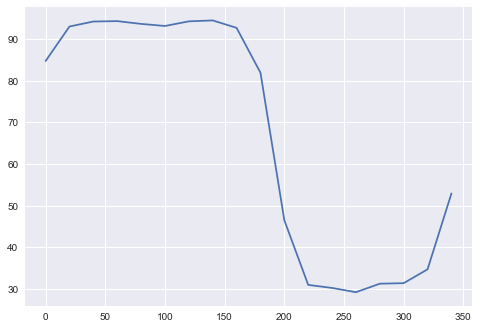

In [38]:
accuracies = []
angles = list(range(0,360,20))
for angle in tqdm(angles):
    test_dataset = FilteredRotatedMNIST(root='./data', train=False, download=True, transform=transform, min_rotation_angle = angle, max_rotation_angle = angle, excluded_labels=[0, 8, 9])
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    accuracies.append(test_accuracy)
plt.plot(angles, accuracies)

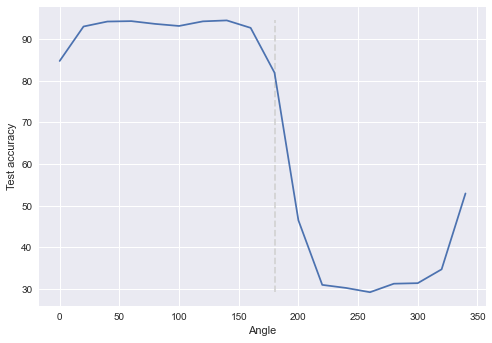

In [50]:
plt.vlines(180, min(accuracies), max(accuracies),'lightgray','--')
plt.plot(angles, accuracies)
plt.xlabel('Angle')
plt.ylabel('Test accuracy')
plt.show()

It seems like the model, when trained on images rotated between 0 and 360 degrees clockwise, performs best at 90 degrees and worst at 270 degrees. Generalises a bit - does better than random (14%) but a lot worse than the other side.

In [ ]:

# Visualize rotated images
images, labels = next(iter(test_loader))
visualize_rotated_images(images, labels)

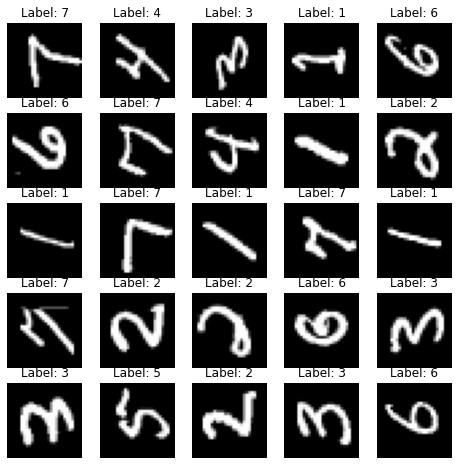

In [18]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 100
x_dataset = FilteredRotatedMNIST(root='./data', train=True, download=True, transform=transform, min_rotation_angle = 90, max_rotation_angle=90, excluded_labels=[0, 8, 9])
train_loader = DataLoader(x_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(train_loader))
visualize_rotated_images(images, labels)